# Modeling

It has been stated in the Business Understanding section, early detection of skin cancer is crucial. The objective is creating a machine learning model that can classify the lession type given an image. 
Models will be created using convolutional neural networks. 
Afterwards, the successes will be compared according to the metrics and the best model will be selected.

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import random
import os
from pathlib import Path

In [2]:
df = pd.read_csv("../data/train.csv")

## Custom CNN Model

### Constants

In [3]:
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE=15
EPOCHS = 2

## Model Building

In [4]:

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax')) # 7, because we have 7 lession types

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

2021-12-29 15:50:08.525841: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0

Firstly, Sequential layer is defined for our neural network which means a linear stack of layers between the input and output. Sequential layer in Keras allows us to build a model layer by layer using ‘add()’ function.

Our first layer is **Conv2D** layer which core block of the CNN. It will perform a dot product of input images, which are seen as 2-dimensional matrices.  The activation function we will be using is Rectified Linear Activation. ReLu has been proven to work well in machine learning models. **BatchNormalization** is a layer that normalizes a mini-batch of data across all observations. **MaxPooling2D** is a pooling layer in CNN that performs dimensionality reduction that preserves locality in feature maps. After pooling layer we will use **Dropout** layer. In machine learning,  regularization is a method to prevent overfitting. Thus, **Dropout** is a approach for regularization in neural networks. 

We will add this quartet in our neural network 3 times in a row. In the last layer, we will add a **dense** layer which means the neurons of the layer are connected to every neuron of its preceding layer.  Since we have 7 classes, the last layer has 7 neurons.Here  **softmax activation** will be used as the activation function. Softmax function outputs a vector that represents the probability distributions of predict probability of classes.

### Early Stop

To prevent overfitting we will use the early stop technique. If the validation loss value does not improve during a certain epoch, the model stops training. This value was selected as 10 epochs.

In [5]:
earlystop = EarlyStopping(patience=10)

### Learning Rate Reduction

The learning rate will be reduced when a accuracy does not increase for 2 steps

In [6]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

### Checkpoint

There are too many images and probably the training time will take too much time. If something happens during training, we have to start all over, so we will save our model weights when validation accuracy increased.

In [7]:
path_weights = Path( '../data/weights/cnn' )
path_weights.mkdir( parents=True, exist_ok=True ) # create a folder for model checkpoints

filepath= os.path.join(path_weights,"model_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [8]:
callbacks = [earlystop, learning_rate_reduction, checkpoint]

### Train Validation Split 


To observe the success of the model during training the data should separate into training and validation. However, the data is not balanced, so we should do a stratified random split of the data. We will split data into 80 percent for training, 20 percent for validation. The random state ensures that the splits that you generate are reproducible.

In [9]:
train_df, validation_df = train_test_split(df, test_size=0.20, stratify=df["lession_type"], random_state=99)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

## Data Augmentation

Data augmentation is a method for oversampling the data. It generates new samples of images using various image transformation techniques such as image rotation, brightness or flipping etc. The benefit of using data augmentation is to prevent overfitting and enable the model to learn better.

### Train Image Generator

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='image_path',
    y_col='lession_type',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 6409 validated image filenames belonging to 7 classes.


### Validation Generator

In [11]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    x_col='image_path',
    y_col='lession_type',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 1603 validated image filenames belonging to 7 classes.


### Test Generated Images

Let's see how the augmented images look like.

In [12]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,  
    x_col='image_path',
    y_col='lession_type',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


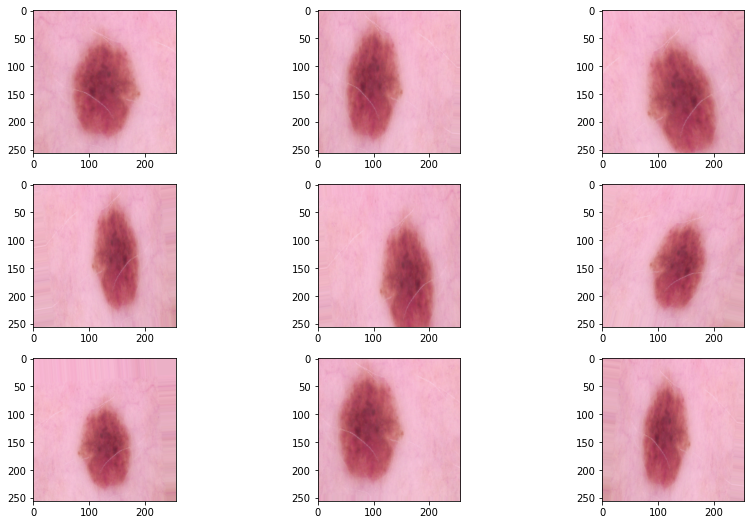

In [13]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [14]:
total_train = train_df.shape[0]
total_validate = validation_df.shape[0]


In [15]:
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-29 15:50:11.783417: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
427/427 [==============================] - 722s 2s/step - loss: 1.5158 - acc: 0.5602 - val_loss: 1.0575 - val_acc: 0.6164

Epoch 00001: val_acc improved from -inf to 0.61635, saving model to ../data/weights/cnn/model_best.hdf5
Epoch 2/2
427/427 [==============================] - 725s 2s/step - loss: 1.0622 - acc: 0.6470 - val_loss: 1.2873 - val_acc: 0.6673

Epoch 00002: val_acc improved from 0.61635 to 0.66730, saving model to ../data/weights/cnn/model_best.hdf5


## Export Model

In [18]:
model.save('../data/weights/cnn/model_latest.hdf5')

## Visualize Result

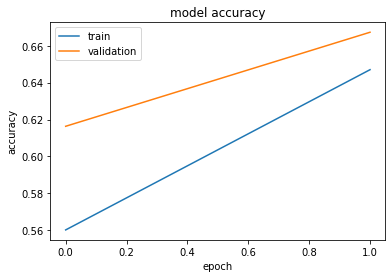

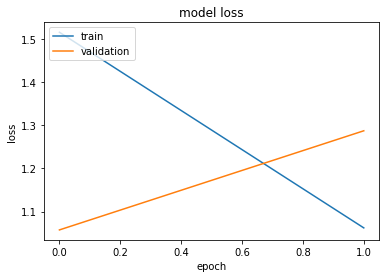

In [26]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../graphs/cnn_model_accuracy_plot.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../graphs/cnn_model_loss_plot.png')
plt.show()